# Compute Streamtrace Residence Time
Computing the length of time a particle may be in a recirculation region can help quantify attributes of the vector field. In the case of a combustion chamber, this can give an indication as to the level of mixing that occurs in that region. Computing residence time with a transient dataset and particle paths is typically going to give a better result, but using this method with steady-state results (or from a single timestep of a transient solution) can help save time as you can get some level of quantification without having to analyze a more expensive transient case.

## Problem setup
In this case we're using a simple 2D flow around a cylinder as an example. This example dataset is included in the Tecplot 360 installation. The first few lines of PyTecplot code here will load the data and seed a few streamtraces

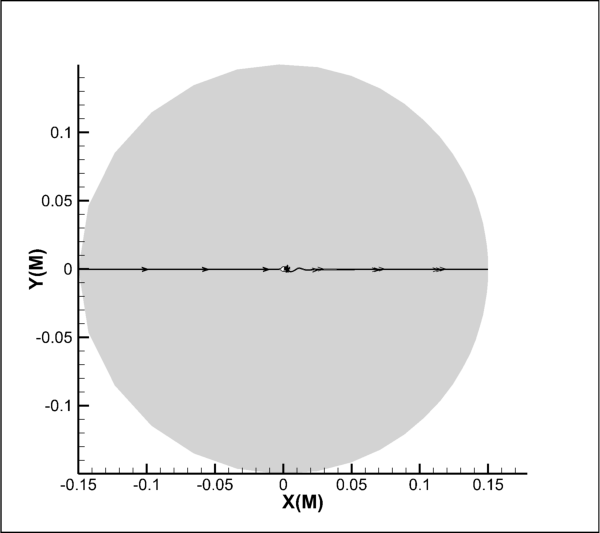

In [1]:
import os
import numpy as np
import tecplot as tp
from tecplot.constant import *

tp.new_layout()
examples_dir = tp.session.tecplot_examples_directory()
ds = tp.data.load_tecplot(os.path.join(examples_dir, "SimpleData", "VortexShedding.plt"))

xvar = ds.variable(0)
yvar = ds.variable(1)
uvar = ds.variable("U(M/S)")
vvar = ds.variable("V(M/S)")

plot = tp.active_frame().plot()
plot.vector.u_variable = uvar
plot.vector.v_variable = vvar
plot.show_streamtraces = True
plot.streamtraces.timing.reset_delta()
plot.streamtraces.add(seed_point=[0.003, 0.001], stream_type=Streamtrace.TwoDLine)
plot.streamtraces.add(seed_point=[0.003, 0], stream_type=Streamtrace.TwoDLine)
plot.streamtraces.add(seed_point=[0.003, -0.001], stream_type=Streamtrace.TwoDLine)
tp.extension.ipython.show()

## Isolate the recirculation region
Once the streamtraces have been placed, we use Value Blanking to constrain the domain (and the streamtraces) to the region of recirculation. We do this because we're only interested in the time that the streamtrace is in this particular region. Notice in the image below that we have three streamtraces. One passes over the top of the cylinder, another passes under the bottom, and the third is constrained to the recirculation region, but eventually exits right.

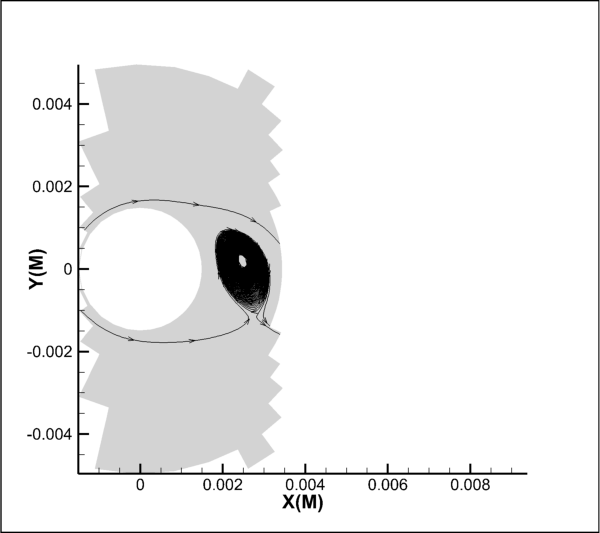

In [2]:
plot = tp.active_frame().plot()
plot.value_blanking.constraint(0).variable = xvar
plot.value_blanking.constraint(0).comparison_value = -0.0015
plot.value_blanking.constraint(0).comparison_operator=RelOp.LessThanOrEqual
plot.value_blanking.constraint(0).active=True

plot.value_blanking.constraint(1).variable = xvar
plot.value_blanking.constraint(1).comparison_value = 0.0035
plot.value_blanking.constraint(1).comparison_operator=RelOp.GreaterThanOrEqual
plot.value_blanking.constraint(1).active=True

plot.value_blanking.constraint(2).variable = yvar
plot.value_blanking.constraint(2).comparison_value = -0.005
plot.value_blanking.constraint(2).comparison_operator=RelOp.LessThanOrEqual
plot.value_blanking.constraint(2).active=True

plot.value_blanking.constraint(3).variable = yvar
plot.value_blanking.constraint(3).comparison_value = 0.005
plot.value_blanking.constraint(3).comparison_operator=RelOp.GreaterThanOrEqual
plot.value_blanking.constraint(3).active=True
plot.value_blanking.active=True

plot.view.fit()
tp.extension.ipython.show()

## Computing the streamtrace residence time
So how do we actually compute the streamtrace residence time?  First we need to extract the streamtraces to new zones, this will allow us to access the raw data associated with each streamtrace.  Each streamtrace is simply a collection of line segments and we'll compute the time of each line segment by dividing the length of that line segment by the velocity magnitude associated with that segment.  We then compute the sum of all the times for all the line segments.

In [3]:
streamtrace_zones = list(tp.active_frame().plot().streamtraces.extract(concatenate = False))
tp.data.operate.execute_equation(equation='{VelMag} = sqrt({U(M/S)}**2 + {V(M/S)}**2)')

In [4]:
def compute_streamtrace_residence_time(streamtrace_zones, velocity_magnitude_variable, 
                                       x_variable=0, y_variable=1, z_variable=None):
    """Compute residence time of one or more streamtraces. You must extract your streamtraces 
    to zones first and then pass those zones to this function.
    See: tecplot.plot.Streamtraces.extract
    
    Parameters:
        streamtrace_zones ('list' of Zones): The set of zones that are the result of extracting streamtraces
        velocity_magnitude_variable (int, str of Variable): Zero-based index,
                `glob-style pattern <fnmatch.fnmatch>` in which case, the first
                match is returned, or a `Variable` object
        x_variable (int, str of Variable): Defaults to the first variable in the 
                dataset. Zero-based index, `glob-style pattern <fnmatch.fnmatch>` in 
                which case, the first match is returned, or a `Variable` object
        y_variable (int, str of Variable): Defaults to the second variable in the 
                dataset. Zero-based index, `glob-style pattern <fnmatch.fnmatch>` in 
                which case, the first match is returned, or a `Variable` object
        z_variable (int, str of Variable): Defaults to None, in which case 2D distance is computed.
                Make sure to pass a valid Z-variable index, variable name or Variable for 3D
                datasets. Zero-based index, `glob-style pattern <fnmatch.fnmatch>` in 
                which case, the first match is returned, or a `Variable` object
                
    Returns:
        A list of computed residence times. The length of list is same as the number of 
        streamtrace_zones passed in.
    """
    residence_times = []
    for zone in streamtrace_zones:
        # Gather the X,Y,Z,Velocity variable arrays
        xvals = zone.values(x_variable)[:]
        yvals = zone.values(y_variable)[:]
        if z_variable:
            zvals = zone.values(z_variable)[:]
        velocity_vals = zone.values(velocity_magnitude_variable)[:]
        
        num_points = len(xvals)
        time_vals = np.zeros(num_points)
        
        # Compute the time of each line segment in the streamtrace zone by
        # computing the length of the segment and divide by the velocity 
        for i in range(1,num_points):
            if z_variable:
                point1 = np.array([xvals[i-1], yvals[i-1], zvals[i-1]])
                point2 = np.array([xvals[i], yvals[i], zvals[i]])
            else:
                point1 = np.array([xvals[i-1], yvals[i-1]])
                point2 = np.array([xvals[i], yvals[i]])
            distance = np.linalg.norm(point2 - point1)
            velocity = velocity_vals[i]
            time_vals[i] = distance/velocity
        
        # Sum all the line segment time values and stuff the result into our result list
        total_time = np.sum(time_vals)
        residence_times.append(total_time)
    return residence_times

In [5]:
residence_times = compute_streamtrace_residence_time(streamtrace_zones, ds.variable("VelMag"))

for zone,time in zip(streamtrace_zones, residence_times):
    print(f"{zone.index}:{zone.name}: {time}")

print("Average residence time:",np.average(residence_times))

60:Streamtrace: 0.00013177149514545912
61:Streamtrace: 0.041846413325704226
62:Streamtrace: 0.0006726944376767342
Average residence time: 0.014216959752842142


## Advanced usage
In this block of code we're going to compute the residence time for streamtraces placed and each point in the zone and apply those values back to the zone so we can see the residence time as a contour value on the data. This is an expensive operation, but can help identify areas of high recirculation.

Adding 412 streams
Extracting streamtraces
Computing VelMag
Computing residence time
Adding Residence Time Variable


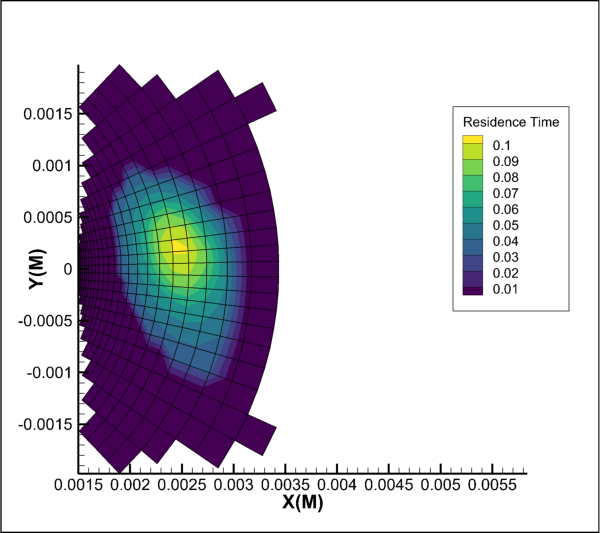

In [6]:
tp.new_layout()
examples_dir = tp.session.tecplot_examples_directory()
ds = tp.data.load_tecplot(os.path.join(examples_dir, "SimpleData", "VortexShedding.plt"))

xvar = ds.variable(0)
yvar = ds.variable(1)
uvar = ds.variable("U(M/S)")
vvar = ds.variable("V(M/S)")

plot = tp.active_frame().plot()
plot.value_blanking.constraint(0).variable = xvar
plot.value_blanking.constraint(0).comparison_value = 0.0015
plot.value_blanking.constraint(0).comparison_operator=RelOp.LessThanOrEqual
plot.value_blanking.constraint(0).active=True

plot.value_blanking.constraint(1).variable = xvar
plot.value_blanking.constraint(1).comparison_value = 0.0035
plot.value_blanking.constraint(1).comparison_operator=RelOp.GreaterThanOrEqual
plot.value_blanking.constraint(1).active=True

plot.value_blanking.constraint(2).variable = yvar
plot.value_blanking.constraint(2).comparison_value = -0.002
plot.value_blanking.constraint(2).comparison_operator=RelOp.LessThanOrEqual
plot.value_blanking.constraint(2).active=True

plot.value_blanking.constraint(3).variable = yvar
plot.value_blanking.constraint(3).comparison_value = 0.002
plot.value_blanking.constraint(3).comparison_operator=RelOp.GreaterThanOrEqual
plot.value_blanking.constraint(3).active=True
plot.value_blanking.active=True

zone = tp.data.extract.extract_blanked_zones(ds.zone(0))[0]

plot = tp.active_frame().plot()
plot.vector.u_variable = uvar
plot.vector.v_variable = vvar
plot.show_streamtraces = True
plot.streamtraces.timing.reset_delta()

xvals = zone.values(xvar)
yvals = zone.values(yvar)

print(f"Adding {len(xvals)} streams")
for x,y in zip(xvals,yvals):
    plot.streamtraces.add(seed_point=[x, y], stream_type=Streamtrace.TwoDLine)
    
print("Extracting streamtraces")
streamtrace_zones = list(tp.active_frame().plot().streamtraces.extract(concatenate = False))

print("Computing VelMag")
tp.data.operate.execute_equation(equation='{VelMag} = sqrt({U(M/S)}**2 + {V(M/S)}**2)')

print("Computing residence time")
residence_times = compute_streamtrace_residence_time(streamtrace_zones, ds.variable("VelMag"))

print("Adding Residence Time Variable")
residence_var = ds.add_variable("Residence Time")
zone.values(residence_var)[:] = residence_times

# Delete all zones except the extracted blanked zone
zones_to_delete = list(ds.zones())
zones_to_delete.remove(zone)
ds.delete_zones(zones_to_delete)

# Setup final plot style to show a contour plot of residence time
plot.fieldmap(zone).show = True
plot.fieldmap(zone).show = True
plot.contour(0).variable = residence_var 
plot.show_contour=True
plot.show_mesh=True
plot.show_streamtraces=False
plot.view.fit()
tp.extension.ipython.show()